<a href="https://colab.research.google.com/github/tasleema17/Assignment3-LLM/blob/main/FINAL_PROJECT_CODE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Install necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Load data flies
flood_data = pd.read_csv(r"/content/IndiaFloodInventory.csv")
rainfall_data = pd.read_csv(r'/content/Sub_Division_IMD_2017.csv')

In [4]:
# Display the first few rows of each dataset
print(flood_data.head())
print(rainfall_data.head())

   Unnamed: 0                   UEI        Start Date          End Date  \
0         563  UEI-IMD-FL-1967-0001  02/07/1967 00:00  08/07/1967 00:00   
1         564  UEI-IMD-FL-1967-0002  22/07/1967 00:00  28/07/1967 00:00   
2         565  UEI-IMD-FL-1967-0003  01/08/1967 00:00  30/08/1967 00:00   
3         566  UEI-IMD-FL-1967-0004  08/09/1967 00:00  09/09/1967 00:00   
4         567  UEI-IMD-FL-1968-0001  22/06/1968 00:00  28/06/1968 00:00   

   Duration(Days) Main Cause  \
0             7.0      flood   
1             7.0      flood   
2            30.0      flood   
3             2.0      flood   
4             7.0      flood   

                                           Districts  \
0                                                NaN   
1                                                NaN   
2                                                NaN   
3  Bhadrak, Dhenkanal, Jajapur, Subarnapur, Nuapa...   
4                                                NaN   

                   

In [5]:
#FLOOD DATA

# Convert date columns to datetime format
flood_data['Start Date'] = pd.to_datetime(flood_data['Start Date'], format='%d/%m/%Y %H:%M')
flood_data['End Date'] = pd.to_datetime(flood_data['End Date'], format='%d/%m/%Y %H:%M')
# Extract date features
flood_data['Year'] = flood_data['Start Date'].dt.year
flood_data['Month'] = flood_data['Start Date'].dt.month
flood_data['Day'] = flood_data['Start Date'].dt.day
flood_data['Season'] = flood_data['Start Date'].dt.month % 12 // 3 + 1  # 1: Winter, 2: Spring, 3: Summer, 4: Monsoon
flood_data['Day of Week'] = flood_data['Start Date'].dt.dayofweek


In [6]:
#RAINFALL DATA

# Melt rainfall_data to get a 'MONTH' and 'RAIN' column
rainfall_data_melted = rainfall_data.melt(
    id_vars=['SUBDIVISION', 'YEAR'],
    value_vars=['JAN', 'FEB', 'MAR', 'APR', 'MAY', 'JUN', 'JUL', 'AUG', 'SEP', 'OCT', 'NOV', 'DEC'],
    var_name='MONTH',
    value_name='RAIN'
)

# Convert month abbreviations to numeric values (1 for January, 2 for February, etc.)
month_map = {
    'JAN': 1, 'FEB': 2, 'MAR': 3, 'APR': 4, 'MAY': 5, 'JUN': 6,
    'JUL': 7, 'AUG': 8, 'SEP': 9, 'OCT': 10, 'NOV': 11, 'DEC': 12
}
rainfall_data_melted['MONTH'] = rainfall_data_melted['MONTH'].map(month_map)

# Ensure 'YEAR' is of type int
rainfall_data_melted['YEAR'] = rainfall_data_melted['YEAR'].astype(int)


In [7]:
#MERGE BOTH DATASETS
# Now merge with flood_data on 'Year' and 'Month'
merged_data = flood_data.merge(
    rainfall_data_melted,
    left_on=['Year', 'Month'],
    right_on=['YEAR', 'MONTH'],
    how='left'
)

# Fill missing rainfall data with 0
merged_data['RAIN'] = merged_data['RAIN'].fillna(0)

# Create additional features based on rainfall
merged_data['Rainfall Anomaly'] = merged_data['RAIN'] - merged_data['RAIN'].mean()
merged_data['Rolling_Rainfall'] = merged_data['RAIN'].rolling(window=3).mean().fillna(0)


In [8]:
# Drop unnecessary columns after merging
merged_data = merged_data.drop(columns=['YEAR', 'UEI', 'Event Source', 'Year', 'Month', 'Day', 'Districts', 'Extent of damage ','Unnamed: 0'])

# Display the result
print("Merged Data Sample:")
print(merged_data.head())


Merged Data Sample:
  Start Date   End Date  Duration(Days) Main Cause  State  Season  \
0 1967-07-02 1967-07-08             7.0      flood  Assam     3.0   
1 1967-07-02 1967-07-08             7.0      flood  Assam     3.0   
2 1967-07-02 1967-07-08             7.0      flood  Assam     3.0   
3 1967-07-02 1967-07-08             7.0      flood  Assam     3.0   
4 1967-07-02 1967-07-08             7.0      flood  Assam     3.0   

   Day of Week                         SUBDIVISION  MONTH   RAIN  \
0          6.0           Andaman & Nicobar Islands    7.0  537.8   
1          6.0                   Arunachal Pradesh    7.0  434.5   
2          6.0                   Assam & Meghalaya    7.0  497.7   
3          6.0              Naga Mani Mizo Tripura    7.0  388.0   
4          6.0  Sub Himalayan West Bengal & Sikkim    7.0  901.6   

   Rainfall Anomaly  Rolling_Rainfall  
0        305.850661          0.000000  
1        202.550661          0.000000  
2        265.750661        490.00000

In [9]:
# Ensure the 'State' column is of type string
merged_data['State'] = merged_data['State'].astype(str)

# Ensure that NaN values in 'State' are replaced with an empty string, then convert to string
merged_data['State'] = merged_data['State'].replace(pd.NA, '').astype(str)

# Split the 'State' column by commas and explode into separate rows
merged_data['State'] = merged_data['State'].str.split(', ')
merged_data_exploded = merged_data.explode('State')

# Remove any rows where 'State' is empty (after handling NaN values)
merged_data_exploded = merged_data_exploded[merged_data_exploded['State'] != '']

# Clean the 'State' column to remove extraneous characters
merged_data_exploded['State'] = merged_data_exploded['State'].str.replace(
    r"[^a-zA-Z,& ]", "", regex=True
)

# Scale or create additional features for rainfall anomalies and rolling rainfall
from sklearn.preprocessing import StandardScaler

# Assuming you have columns 'RAIN', 'Rainfall Anomaly', and 'Rolling_Rainfall'
rainfall_features = ['RAIN', 'Rainfall Anomaly', 'Rolling_Rainfall']
scaler = StandardScaler()
merged_data_exploded[rainfall_features] = scaler.fit_transform(merged_data_exploded[rainfall_features])


In [10]:
# Check the shape of the DataFrame
rows, columns = merged_data_exploded.shape
print(f"The DataFrame has {rows} rows and {columns} columns.")


The DataFrame has 161268 rows and 12 columns.


In [11]:
# Drop duplicate rows
merged_data_exploded = merged_data_exploded.drop_duplicates()

# Handle missing values using .loc
# For 'Main Cause', fill with 'Unknown'
merged_data_exploded.loc[:, 'Main Cause'] = merged_data_exploded['Main Cause'].fillna('Unknown')

# For 'SUBDIVISION', fill with 'Unknown'
merged_data_exploded.loc[:, 'SUBDIVISION'] = merged_data_exploded['SUBDIVISION'].fillna('Unknown')

# For 'RAIN', fill with the median value
median_rain = merged_data_exploded['RAIN'].median()
merged_data_exploded.loc[:, 'RAIN'] = merged_data_exploded['RAIN'].fillna(median_rain)

# Assuming 'merged_data_exploded' is your DataFrame
merged_data_exploded = merged_data_exploded.dropna(subset=['MONTH'])

# Display the updated number of rows and columns
#print("Number of rows and columns after dropping missing MONTH values:", merged_data_exploded.shape)


# Verify the data cleaning
print("Missing values after cleaning:\n", merged_data_exploded.isnull().sum())
print(f"\nNumber of rows and columns after cleaning: {merged_data_exploded.shape}")


Missing values after cleaning:
 Start Date          0
End Date            0
Duration(Days)      0
Main Cause          0
State               0
Season              0
Day of Week         0
SUBDIVISION         0
MONTH               0
RAIN                0
Rainfall Anomaly    0
Rolling_Rainfall    0
dtype: int64

Number of rows and columns after cleaning: (157520, 12)


In [12]:
#DATA CHECKS
# Check for any remaining missing values
print("Missing values per column:\n", merged_data_exploded.isnull().sum())
# Check data types again
print("\nData types of each column:\n", merged_data_exploded.dtypes)
# Check for duplicates
duplicates = merged_data_exploded.duplicated().sum()
print(f"\nNumber of duplicate rows: {duplicates}")
# Summary statistics
print("\nSummary statistics:\n", merged_data_exploded.describe())

Missing values per column:
 Start Date          0
End Date            0
Duration(Days)      0
Main Cause          0
State               0
Season              0
Day of Week         0
SUBDIVISION         0
MONTH               0
RAIN                0
Rainfall Anomaly    0
Rolling_Rainfall    0
dtype: int64

Data types of each column:
 Start Date          datetime64[ns]
End Date            datetime64[ns]
Duration(Days)             float64
Main Cause                  object
State                       object
Season                     float64
Day of Week                float64
SUBDIVISION                 object
MONTH                      float64
RAIN                       float64
Rainfall Anomaly           float64
Rolling_Rainfall           float64
dtype: object

Number of duplicate rows: 0

Summary statistics:
                           Start Date                       End Date  \
count                         157520                         157520   
mean   1998-06-11 16:46:39.918740480  1

In [13]:
# Check min and max dates
print("\nDate range in Start Date:")
print("Min:", merged_data_exploded['Start Date'].min())
print("Max:", merged_data_exploded['Start Date'].max())

print("\nDate range in End Date:")
print("Min:", merged_data_exploded['End Date'].min())
print("Max:", merged_data_exploded['End Date'].max())



Date range in Start Date:
Min: 1967-07-02 00:00:00
Max: 2017-12-10 00:00:00

Date range in End Date:
Min: 1967-07-08 00:00:00
Max: 2017-12-10 00:00:00


In [14]:
# Count the number of rows with specific flood-related terms in "Main Cause"
flood_terms = merged_data_exploded['Main Cause'].str.lower().str.contains('flood|heavy floods')

# Number of rows with flood-related causes
num_flood_rows = merged_data_exploded[flood_terms].shape[0]

# Number of rows without flood-related causes
num_non_flood_rows = merged_data_exploded[~flood_terms].shape[0]

print("Number of rows with flood-related causes (flood, floods, heavy floods):", num_flood_rows)
print("Number of rows with other causes:", num_non_flood_rows)


Number of rows with flood-related causes (flood, floods, heavy floods): 35352
Number of rows with other causes: 122168


In [15]:
# Replace 'floods' and 'heavy floods' with 'flood' in "Main Cause"
merged_data_exploded['Main Cause'] = merged_data_exploded['Main Cause'].str.lower().replace(
    {'floods': 'flood', 'heavy floods': 'flood'}, regex=True
)

In [16]:
import pandas as pd

# Assuming your dataframe is named 'merged_data_exploded'
def categorize_cause(cause):
    # Convert to lowercase for uniform comparison
    cause_lower = cause.lower()

    # Category 1: Any term implying "flood" or "flash flood"
    if "flood" in cause_lower:
        return "flood"
    # Category 2: Descriptions mentioning "heavy rains," "landslide," or "cloud burst"
    elif any(term in cause_lower for term in ["heavy rains", "landslide", "cloud burst", "heavy rain"]):
        return "no flood"
    # Default to "no flood" if it doesn't match any criteria
    else:
        return "no flood"

# Apply the categorization function to the 'Main Cause' column
merged_data_exploded['Flood Occurance'] = merged_data_exploded['Main Cause'].apply(categorize_cause)

# Display the updated DataFrame with the new categorization
print(merged_data_exploded[['Main Cause', 'Flood Occurance']])
#merged_data_exploded = merged_data_exploded.drop(columns=['YEAR'])


       Main Cause Flood Occurance
0           flood           flood
1           flood           flood
2           flood           flood
3           flood           flood
4           flood           flood
...           ...             ...
154653      flood           flood
154654      flood           flood
154655      flood           flood
154656      flood           flood
154657      flood           flood

[157520 rows x 2 columns]


In [17]:
merged_data_exploded = merged_data_exploded.drop(columns=['Main Cause'])

In [18]:
# Replace 'flood' with 1 and 'no flood' with 0 in the 'Flood Occurrence' column
merged_data_exploded['Flood Occurance'] = merged_data_exploded['Flood Occurance'].replace({'flood': 1, 'no flood': 0})


<ipython-input-18-dd9693d93e7d>:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  merged_data_exploded['Flood Occurance'] = merged_data_exploded['Flood Occurance'].replace({'flood': 1, 'no flood': 0})


In [19]:
# Count the occurrences of 'flood' and 'no flood' in the 'Flood Occurance' column
flood_counts = merged_data_exploded['Flood Occurance'].value_counts()

# Display the result
print(flood_counts)

Flood Occurance
0    122168
1     35352
Name: count, dtype: int64


In [20]:
import pandas as pd

# Define corrections dictionary to standardize state names
state_corrections = {
    "Jammu & Kashmir": "Jammu And Kashmir",
    "Daman & Diu": "Daman And Diu",
    "Maharastra": "Maharashtra",
    "Madras": "Tamil Nadu",
    "Tamilnadu": "Tamil Nadu",
    "Chennai": "Tamil Nadu",
    "Daman And Diu": "Daman,Diu",
    "Parts Of Maharastra": "Maharashtra",
    "East Rajasthan": "Rajasthan"

    # Add more mappings as needed
}

# Assuming your data is loaded into a DataFrame called merged_data_exploded
# Clean the 'State' column: remove leading/trailing spaces, apply title case, and apply corrections
merged_data_exploded['State'] = (
    merged_data_exploded['State']
    .str.strip()
    .str.title()
    .replace(state_corrections)
)

# Save the cleaned data to 'final_data.csv'
#merged_data_exploded.to_csv('/mnt/data/final_data.csv', index=False)

# Notify the user where the cleaned file is saved
#print("Cleaned data has been saved to '/mnt/data/final_data.csv'")
#

In [21]:
print(merged_data_exploded.head())

  Start Date   End Date  Duration(Days)  State  Season  Day of Week  \
0 1967-07-02 1967-07-08             7.0  Assam     3.0          6.0   
1 1967-07-02 1967-07-08             7.0  Assam     3.0          6.0   
2 1967-07-02 1967-07-08             7.0  Assam     3.0          6.0   
3 1967-07-02 1967-07-08             7.0  Assam     3.0          6.0   
4 1967-07-02 1967-07-08             7.0  Assam     3.0          6.0   

                          SUBDIVISION  MONTH      RAIN  Rainfall Anomaly  \
0           Andaman & Nicobar Islands    7.0  1.412492          1.412492   
1                   Arunachal Pradesh    7.0  0.933930          0.933930   
2                   Assam & Meghalaya    7.0  1.226719          1.226719   
3              Naga Mani Mizo Tripura    7.0  0.718508          0.718508   
4  Sub Himalayan West Bengal & Sikkim    7.0  3.097883          3.097883   

   Rolling_Rainfall  Flood Occurance  
0         -1.500524                1  
1         -1.500524                1  

In [22]:
#from imblearn.under_sampling import RandomUnderSampler
#import pandas as pd

# Step 1: Separate features (X) and target (y)
#X = merged_data_exploded.drop(columns=['Flood Occurance'])
#y = merged_data_exploded['Flood Occurance']

# Step 2: Apply Random UnderSampling
#rus = RandomUnderSampler(random_state=42)
#X_resampled, y_resampled = rus.fit_resample(X, y)

# Step 3: Combine X_resampled and y_resampled to create the resampled dataset
#merged_data_resampled = pd.concat([X_resampled, y_resampled], axis=1)

# Step 4: Verify the balanced distribution of 'Flood Occurance'
#print("Balanced Class Distribution (After Undersampling):\n", merged_data_resampled['Flood Occurance'].value_counts())

# Optionally, update merged_data_exploded with the resampled data
#merged_data_exploded = merged_data_resampled


In [23]:
# Count the occurrences of 'flood' and 'no flood' in the 'Flood Occurance' column
#flood_counts = merged_data_exploded['Flood Occurance'].value_counts()

# Display the result
#print(flood_counts)

In [24]:
# Check the shape of the DataFrame
#rows, columns = merged_data_exploded.shape
#print(f"The DataFrame has {rows} rows and {columns} columns.")


INSIGHTS

<ipython-input-25-c734123c77ef>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=merged_data_exploded, x='SUBDIVISION', y='RAIN', palette='viridis')


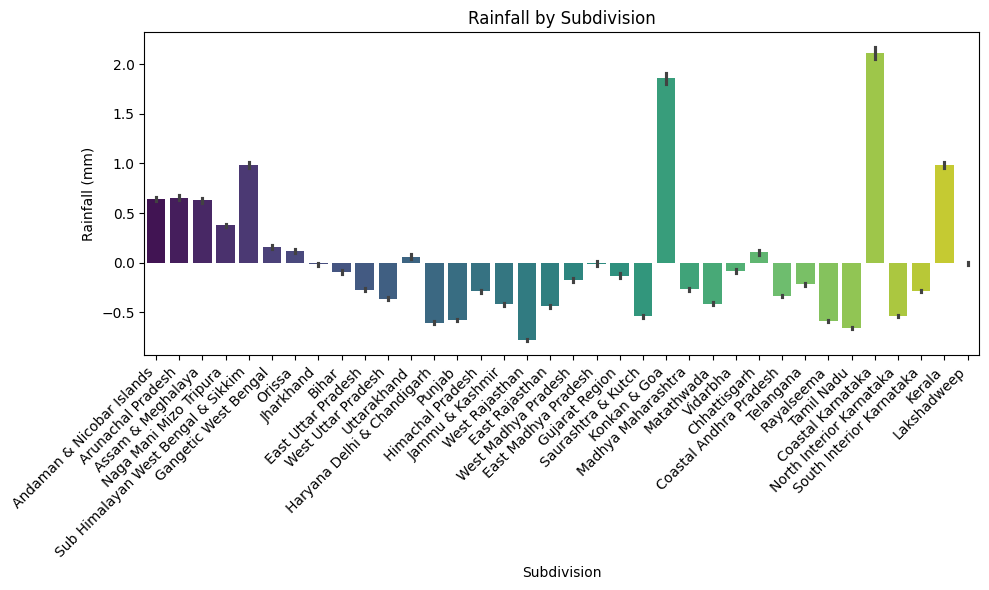

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns

# Rainfall Comparison by Subdivision
plt.figure(figsize=(10, 6))
sns.barplot(data=merged_data_exploded, x='SUBDIVISION', y='RAIN', palette='viridis')
plt.xticks(rotation=45, ha='right')
plt.title("Rainfall by Subdivision")
plt.ylabel("Rainfall (mm)")
plt.xlabel("Subdivision")
plt.tight_layout()
plt.show()

<ipython-input-26-c92b393782aa>:12: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=rainfall_per_state, x='State', y='RAIN', palette='muted', ci=None)
<ipython-input-26-c92b393782aa>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=rainfall_per_state, x='State', y='RAIN', palette='muted', ci=None)


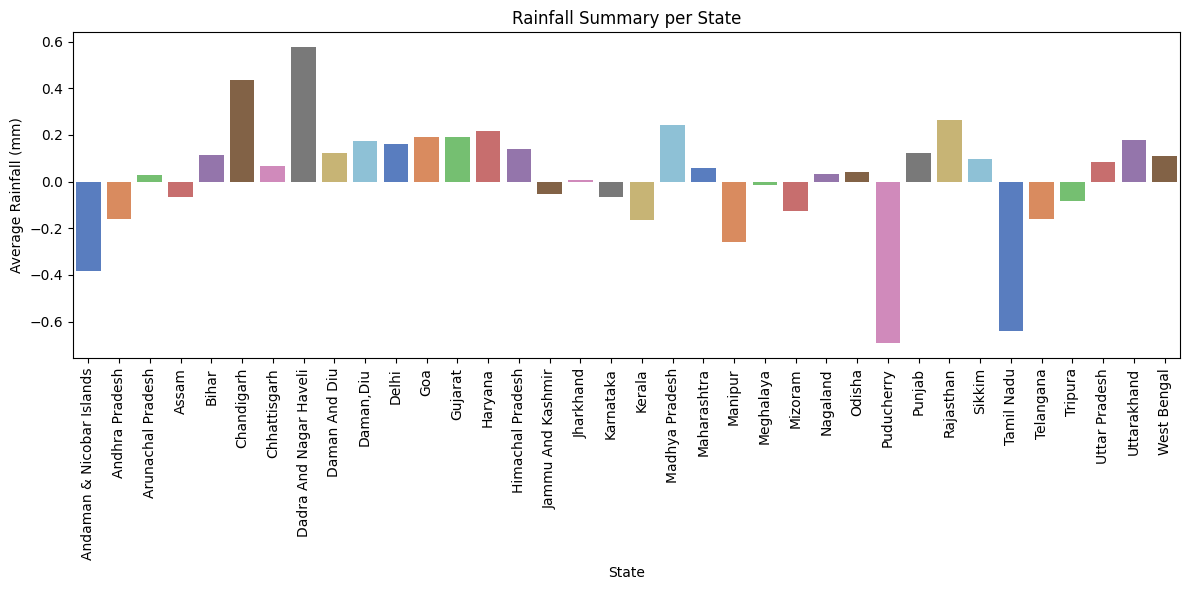

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns

# Clean the 'State' column: remove leading/trailing spaces and make all entries lowercase
merged_data_exploded['State'] = merged_data_exploded['State'].str.strip().str.title()

# Group by 'State' and calculate the average rainfall per state
rainfall_per_state = merged_data_exploded.groupby('State')['RAIN'].mean().reset_index()

# Create the bar plot
plt.figure(figsize=(12, 6))  # Increase the figure size to make more room
sns.barplot(data=rainfall_per_state, x='State', y='RAIN', palette='muted', ci=None)

# Add title and labels
plt.title("Rainfall Summary per State")
plt.xlabel("State")
plt.ylabel("Average Rainfall (mm)")

# Rotate x-axis labels to prevent overlap
plt.xticks(rotation=90)

# Adjust layout to ensure the labels fit nicely
plt.tight_layout()

# Show the plot
plt.show()


<ipython-input-27-983709f21549>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_states, x='State', y='RAIN', palette='magma')


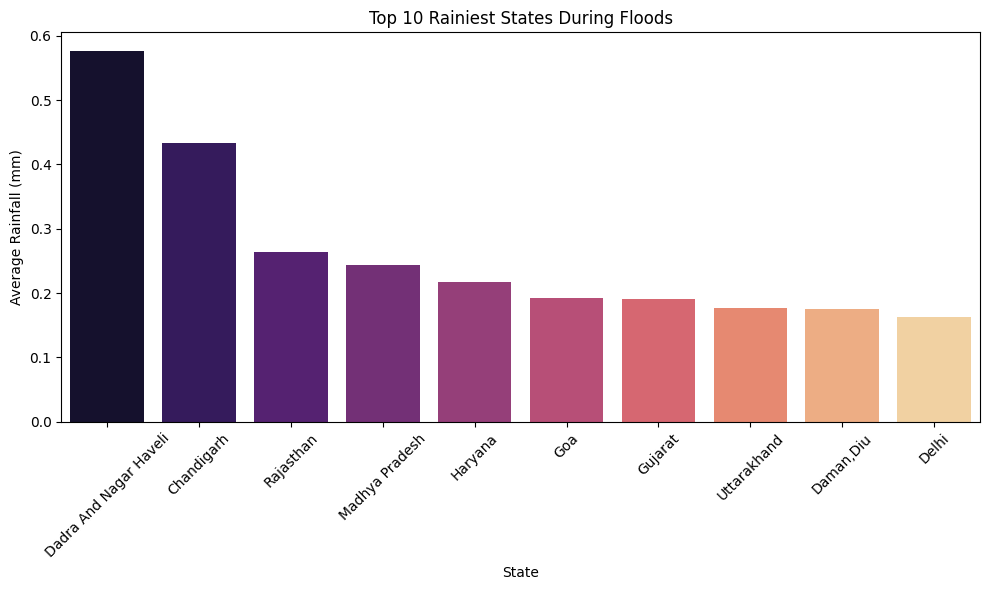

In [27]:
# 4. Top 10 Rainiest States During Floods
top_states = merged_data_exploded.groupby('State')['RAIN'].mean().nlargest(10).reset_index()
plt.figure(figsize=(10, 6))
sns.barplot(data=top_states, x='State', y='RAIN', palette='magma')
plt.title("Top 10 Rainiest States During Floods")
plt.xlabel("State")
plt.ylabel("Average Rainfall (mm)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

MODEL EVALUATION

---



---



In [33]:
print(merged_data_exploded.columns)


Index(['Start Date', 'End Date', 'Duration(Days)', 'Season', 'Day of Week',
       'MONTH', 'RAIN', 'Rainfall Anomaly', 'Rolling_Rainfall',
       'Flood Occurance', 'State_Andhra Pradesh', 'State_Arunachal Pradesh',
       'State_Assam', 'State_Bihar', 'State_Chandigarh', 'State_Chhattisgarh',
       'State_Dadra And Nagar Haveli', 'State_Daman And Diu',
       'State_Daman,Diu', 'State_Delhi', 'State_Goa', 'State_Gujarat',
       'State_Haryana', 'State_Himachal Pradesh', 'State_Jammu And Kashmir',
       'State_Jharkhand', 'State_Karnataka', 'State_Kerala',
       'State_Madhya Pradesh', 'State_Maharashtra', 'State_Manipur',
       'State_Meghalaya', 'State_Mizoram', 'State_Nagaland', 'State_Odisha',
       'State_Puducherry', 'State_Punjab', 'State_Rajasthan', 'State_Sikkim',
       'State_Tamil Nadu', 'State_Telangana', 'State_Tripura',
       'State_Uttar Pradesh', 'State_Uttarakhand', 'State_West Bengal',
       'SUBDIVISION_Arunachal Pradesh', 'SUBDIVISION_Assam & Meghalaya',
 

In [32]:
#random Forest
#Identify numeric columns
numeric_cols = merged_data_exploded.select_dtypes(include='number').columns

#Fill missing values in numeric columns with the mean of each column
merged_data_exploded[numeric_cols] = merged_data_exploded[numeric_cols].fillna(merged_data_exploded[numeric_cols].mean())

# Alternatively, fill missing values for categorical columns if necessary
merged_data_exploded = merged_data_exploded.fillna({'State': 'Unknown', 'SUBDIVISION': 'Unknown'})

# preprocessing steps
# Convert categorical variables to dummy/indicator variables
merged_data_exploded = pd.get_dummies(merged_data_exploded, columns=['State', 'SUBDIVISION'], drop_first=True)

# Select features and target variable
X = merged_data_exploded.drop(columns=['Flood Occurance', 'Start Date', 'End Date'])  # Drop unnecessary columns
y = merged_data_exploded['Flood Occurance']

# Scale numerical features if necessary
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X[['RAIN', 'MONTH', 'Duration(Days)']] = scaler.fit_transform(X[['RAIN', 'MONTH', 'Duration(Days)']])

# Split data into training and testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
#
#print('X_train:', x_train.shape)
#add others





# Initialize the model
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators=100, random_state=42)
# Import necessary metrics for ROC-AUC
from sklearn.metrics import roc_auc_score, roc_curve

# Train the model
model.fit(X_train, y_train)

# Predict and evaluate
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Predict probabilities for the positive class (1)
y_proba = model.predict_proba(X_test)[:, 1]
# Calculate ROC-AUC
roc_auc = roc_auc_score(y_test, y_proba)

print("Model Evaluation Metrics:")
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("roc-auc:", roc_auc)


KeyError: "None of [Index(['State', ' SUBDIVISION'], dtype='object')] are in the [columns]"

In [29]:
# Import necessary metrics for ROC-AUC
from sklearn.metrics import roc_auc_score, roc_curve

# Predict probabilities for the positive class (1)
y_proba = model.predict_proba(X_test)[:, 1]

# Calculate ROC-AUC
roc_auc = roc_auc_score(y_test, y_proba)

print("Model Evaluation Metrics:")
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("ROC-AUC:", roc_auc)


Model Evaluation Metrics:
Accuracy: 0.8325980003174099
Precision: 0.6585365853658537
Recall: 0.5271646859083192
F1 Score: 0.5855728429985856
ROC-AUC: 0.8502567057445503


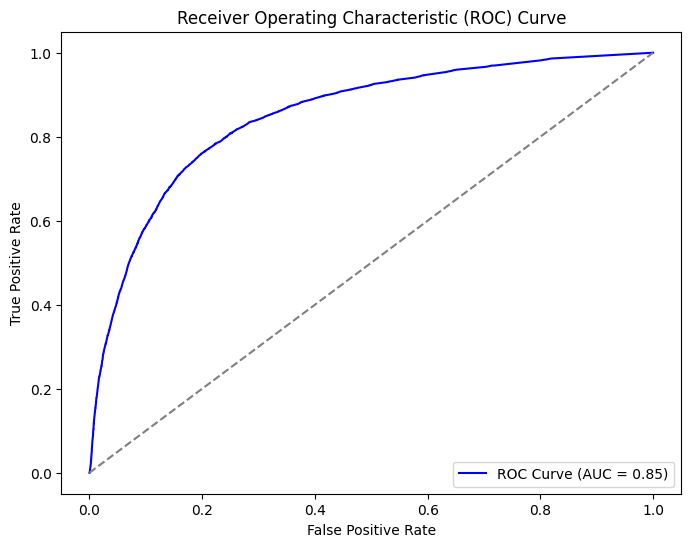

In [30]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

# Get the predicted probabilities for the positive class
y_proba = model.predict_proba(X_test)[:, 1]

# Calculate the ROC curve points
fpr, tpr, thresholds = roc_curve(y_test, y_proba)

# Calculate the ROC-AUC score
roc_auc = roc_auc_score(y_test, y_proba)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='grey', linestyle='--')  # Dashed diagonal for random guessing
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


In [157]:
#Logistic Regression model
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features only on the training data
scaler = StandardScaler()
X_train_scaled = X_train.copy()
X_train_scaled[['RAIN', 'MONTH', 'Duration(Days)']] = scaler.fit_transform(X_train[['RAIN', 'MONTH', 'Duration(Days)']])

# Apply the same scaling to the test data
X_test_scaled = X_test.copy()
X_test_scaled[['RAIN', 'MONTH', 'Duration(Days)']] = scaler.transform(X_test[['RAIN', 'MONTH', 'Duration(Days)']])

# Initialize the Logistic Regression model with changes
log_reg = LogisticRegression(random_state=42,
                             max_iter=1000,  # Increased max_iter for more iterations
                             solver='liblinear',  # Use the 'liblinear' solver which works well for smaller datasets
                             C=1.0)  # Regularization strength (try adjusting if necessary)

# Train the model with scaled training data
log_reg.fit(X_train_scaled, y_train)

# Predict and evaluate on the test set
y_pred_log_reg = log_reg.predict(X_test_scaled)

# Evaluate the performance
accuracy_log_reg = accuracy_score(y_test, y_pred_log_reg)
precision_log_reg = precision_score(y_test, y_pred_log_reg)
recall_log_reg = recall_score(y_test, y_pred_log_reg)
f1_log_reg = f1_score(y_test, y_pred_log_reg)

# Print the evaluation metrics
print("Logistic Regression Model Evaluation Metrics:")
print("Accuracy:", accuracy_log_reg)
print("Precision:", precision_log_reg)
print("Recall:", recall_log_reg)
print("F1 Score:", f1_log_reg)


Logistic Regression Model Evaluation Metrics:
Accuracy: 0.6955660844353299
Precision: 0.7180205415499533
Recall: 0.6492190797804981
F1 Score: 0.681888716470849


In [120]:
from sklearn.svm import SVC

# Initialize the SVM model
svm = SVC(random_state=42)

# Train the model
svm.fit(X_train, y_train)

# Predict and evaluate
y_pred_svm = svm.predict(X_test)
accuracy_svm = accuracy_score(y_test, y_pred_svm)
precision_svm = precision_score(y_test, y_pred_svm)
recall_svm = recall_score(y_test, y_pred_svm)
f1_svm = f1_score(y_test, y_pred_svm)

print("SVM Model Evaluation Metrics:")
print("Accuracy:", accuracy_svm)
print("Precision:", precision_svm)
print("Recall:", recall_svm)
print("F1 Score:", f1_svm)


SVM Model Evaluation Metrics:
Accuracy: 0.5393536524998233
Precision: 0.5290373127019881
Recall: 0.7600956803151823
F1 Score: 0.6238595680794549
